# 01 · Análisis exploratorio (EDA)

**Objetivo.**  
1. Cargar el dataset `sample_data_0006_part_00.parquet` con uso óptimo de memoria.  
2. Verificar integridad de columnas, tipos y valores nulos.  
3. Detectar duplicados exactos y semánticos.  
4. Normalizar la columna de fecha a hora local (UTC-5, América/Bogotá).  
5. Guardar una versión depurada `cache/df_clean.parquet` para los siguientes notebooks.

> Nota : se conservan los nombres de columna originales tal como vienen en el Parquet.


In [ ]:
# A.1 · Importaciones, configuraciones y utilidades
import time
from pathlib import Path
import pandas as pd
import numpy as np
import logging

# Configuración global
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
)
def log_step(msg: str):
    logging.info(msg)

SEED = 42
np.random.seed(SEED)

pd.options.display.max_columns = 120
pd.options.display.float_format = "{:,.4f}".format

# Rutas de acceso
DATA_DIR  = Path(".")
CACHE_DIR = Path("./cache")
CACHE_DIR.mkdir(exist_ok=True)
FILE_PARQUET = DATA_DIR / "sample_data_0006_part_00.parquet"

In [ ]:
# A.2 · Carga de datos y tiempo de cómputo
log_step("Leyendo Parquet …")
t0 = time.time()
df = pd.read_parquet(FILE_PARQUET)
log_step(f"Carga completada en {time.time() - t0:.2f} s  |  filas: {len(df):,}")

2025-06-29 00:27:07 | INFO | Leyendo Parquet …
2025-06-29 00:27:41 | INFO | Carga completada en 34.22 s  |  filas: 10,758,418


In [ ]:
# A.3 · Memoria
info_df = (
    df.memory_usage(deep=True)
      .reset_index(name="bytes")
      .assign(MB=lambda d: d.bytes / 1024**2)
      .sort_values("MB", ascending=False)
)
log_step(f"Uso total de memoria inicial: {info_df.MB.sum():.2f} MB")
info_df.head(10)

2025-06-29 00:28:00 | INFO | Uso total de memoria inicial: 5952.88 MB


,index,bytes,MB
7,transaction_amount,1204942816,"1,149.1230"
1,merchant_id,871431858,831.0622
2,_id,871431858,831.0622
3,subsidiary,871431858,831.0622
5,account_number,871431858,831.0622
6,user_id,871431858,831.0622
8,transaction_type,593880119,566.3682
4,transaction_date,86067344,82.0802
0,Index,132,0.0001


In [ ]:
# A.4 · Tipos de datos y nulos
log_step("Tipos de datos y porcentaje de nulos")
types_nas = (
    df.isna().mean()
      .to_frame("pct_null")
      .join(df.dtypes.rename("dtype"))
      .sort_values("pct_null", ascending=False)
)
types_nas.head(12)

2025-06-29 00:28:00 | INFO | Tipos de datos y porcentaje de nulos


,pct_null,dtype
merchant_id,0.0000,object
_id,0.0000,object
subsidiary,0.0000,object
transaction_date,0.0000,datetime64[ns]
account_number,0.0000,object
user_id,0.0000,object
transaction_amount,0.0000,object
transaction_type,0.0000,object


In [ ]:
# A.5 · Normalización de la columna de fecha
DATE_COL = "transaction_date"

df[DATE_COL] = (
    pd.to_datetime(df[DATE_COL], utc=True, errors="coerce")
      .dt.tz_convert("America/Bogota")
      .dt.tz_localize(None)
)

log_step(f"Fechas invalidas (NaT): {(df[DATE_COL].isna()).sum():,}")

2025-06-29 00:28:07 | INFO | Fechas invalidas (NaT): 0


In [ ]:
# A.6 · Duplicados exactos y semánticos
PRIMARY_KEY = "_id"  

dup_exact = df.duplicated(subset=[PRIMARY_KEY]).sum()
log_step(f"Duplicados exactos por {PRIMARY_KEY}: {dup_exact:,}")

dup_semantic_cols = ["user_id", "transaction_date", "transaction_amount", "transaction_type"]
dup_semantic = df.duplicated(subset=dup_semantic_cols).sum()
log_step(f"Duplicados semánticos (conjunto clave): {dup_semantic:,}")

2025-06-29 00:28:15 | INFO | Duplicados exactos por _id: 7
2025-06-29 00:28:40 | INFO | Duplicados semánticos (conjunto clave): 13


In [ ]:
# A.7 · Cast optimizado y robusto

# 1) INT64  → INT32 (cuando rango lo permite)                        
for col in df.select_dtypes(include="int64").columns:
    cmin, cmax = df[col].min(), df[col].max()
    if (cmin >= np.iinfo("int32").min) and (cmax <= np.iinfo("int32").max):
        df[col] = df[col].astype("int32")
        log_step(f"{col}: int64 → int32")

# 2) OBJECT  → INT32 (si son dígitos)  o  → CATEGORY                 
obj_cols = df.select_dtypes(include="object").columns

for col in obj_cols:
    ser = df[col].dropna()

    # Convertimos solo el subconjunto no-nulo a str para la prueba
    if not ser.empty and ser.astype(str).str.isdigit().all():
        tmp = pd.to_numeric(df[col], errors="coerce", downcast="integer")
        if tmp.max() <= np.iinfo("int32").max:
            df[col] = tmp.astype("int32")
            log_step(f"{col}: object (dígitos) → int32")
        else:
            df[col] = tmp.astype("int64")
            log_step(f"{col}: object (dígitos) → int64")
    else:
        # Heurística: si <50 % de valores son únicos, conviene category
        uniq = ser.nunique(dropna=True)
        if uniq / len(ser) <= 0.50:
            df[col] = df[col].astype("category")
            log_step(f"{col}: object → category (card={uniq})")
        else:
            log_step(f"{col}: se mantiene en object (card={uniq})")

# 3) FLOAT64 → FLOAT32                                               
float64_cols = df.select_dtypes(include="float64").columns
df[float64_cols] = df[float64_cols].astype("float32")
log_step("Casting numérico completado")

# 4) Informe de memoria                                              
mem_mb = df.memory_usage(deep=True).sum() / 1024**2
log_step(f"Memoria tras optimización v2: {mem_mb:.2f} MB")

2025-06-29 00:28:51 | INFO | merchant_id: object → category (card=3)
2025-06-29 00:29:01 | INFO | _id: se mantiene en object (card=10758411)
2025-06-29 00:29:05 | INFO | subsidiary: object → category (card=16052)
2025-06-29 00:29:18 | INFO | account_number: object → category (card=1954040)
2025-06-29 00:29:29 | INFO | user_id: object → category (card=1948844)
2025-06-29 00:29:54 | INFO | transaction_amount: object → category (card=18554)
2025-06-29 00:29:57 | INFO | transaction_type: object → category (card=2)
2025-06-29 00:29:57 | INFO | Casting numérico completado
2025-06-29 00:30:01 | INFO | Memoria tras optimización v2: 1491.50 MB


In [ ]:
# A.8 · Conversión numérica + deduplicación

# 1) transaction_amount --> float32
df["transaction_amount"] = (
    pd.to_numeric(df["transaction_amount"], errors="coerce")
      .astype("float32")
)
log_step("transaction_amount convertido a float32")

# 2) Eliminar duplicados exactos por _id 
before = len(df)
df = df.drop_duplicates(subset=["_id"], keep="first")

# 3) Eliminar duplicados semánticos
dup_sem_cols = ["user_id", "transaction_date", "transaction_amount", "transaction_type"]
df = df.drop_duplicates(subset=dup_sem_cols, keep="first")

after = len(df)
log_step(f"Filas eliminadas por deduplicación: {before - after:,}")

# 4) Reporte de memoria tras convertir transaction_amount
mem_mb = df.memory_usage(deep=True).sum() / 1024**2
log_step(f"Memoria tras fix: {mem_mb:.2f} MB")

2025-06-29 00:30:17 | INFO | transaction_amount convertido a float32
2025-06-29 00:30:32 | INFO | Filas eliminadas por deduplicación: 16
2025-06-29 00:30:35 | INFO | Memoria tras fix: 1591.61 MB


In [ ]:
# A.9 · Verificación final de duplicados
dup_exact_final = df.duplicated(subset=["_id"]).sum()
dup_sem_final   = df.duplicated(
    subset=["user_id", "transaction_date", "transaction_amount", "transaction_type"]
).sum()

log_step(f"Duplicados exactos restantes: {dup_exact_final}")
log_step(f"Duplicados semánticos restantes: {dup_sem_final}")


2025-06-29 00:30:43 | INFO | Duplicados exactos restantes: 0
2025-06-29 00:30:43 | INFO | Duplicados semánticos restantes: 0


In [ ]:
# A.10 · Down-cast numéricos para optimizar memoria
num_cols_float = df.select_dtypes(include="float64").columns
num_cols_int   = df.select_dtypes(include="int64").columns

df[num_cols_float] = df[num_cols_float].astype("float32")
df[num_cols_int]   = df[num_cols_int].astype("int32")

log_step("Casting completado")
info_after = df.memory_usage(deep=True).sum() / 1024**2
log_step(f"Uso total de memoria tras optimización: {info_after:.2f} MB")

2025-06-29 00:30:43 | INFO | Casting completado
2025-06-29 00:30:46 | INFO | Uso total de memoria tras optimización: 1591.61 MB


In [ ]:
# A.11 · Persistencia del DataFrame limpio
CACHE_FILE = CACHE_DIR / "df_clean.parquet"
df.to_parquet(CACHE_FILE, compression="snappy")
log_step(f"Dataset limpio cacheado en {CACHE_FILE}")

2025-06-29 00:31:18 | INFO | Dataset limpio cacheado en cache\df_clean.parquet


## B · Exploración descriptiva

En esta sección:

1. **B.1** Distribución log₁₀ de `transaction_amount`.  
2. **B.2** Volumen horario promedio con banda intercuartílica (p25-p75).  
3. **B.3** Estadísticos p50, p95, p99 por `transaction_type`.

Todas las figuras usan la muestra completa (≈ 10.75 M filas) con escalas y etiquetas legibles.


2025-06-29 01:02:14 | INFO | Figura B.1 generada
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  func(*args, **kwargs)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8321 (\N{SUBSCRIPT ONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
c:\ProgramData\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8320 (\N{SUBSCRIPT ZERO}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


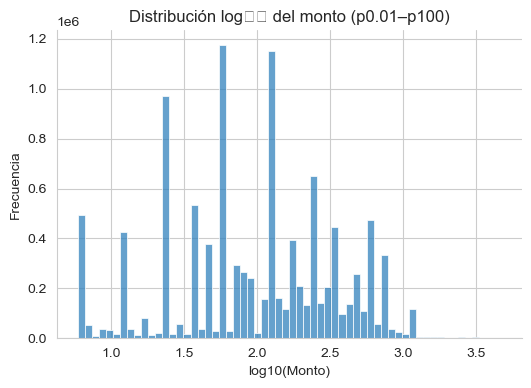

In [ ]:
# B.1 · Histograma log10 del monto
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

fig, ax = plt.subplots(figsize=(6,4))
sns.histplot(
    np.log10(df["transaction_amount"].clip(lower=0.01)),
    bins=60,
    color="#3182bd",
    ax=ax,
)
ax.set_xlabel("log10(Monto)")
ax.set_ylabel("Frecuencia")
ax.set_title("Distribución log₁₀ del monto (p0.01–p100)")
sns.despine(ax=ax)

log_step("Figura B.1 generada")

2025-06-29 01:02:20 | INFO | Figura B.2 generada


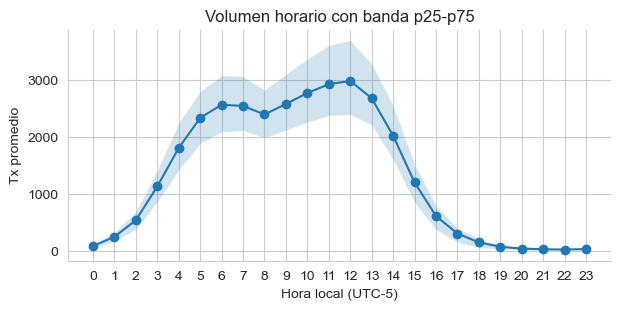

In [ ]:
# B.2 · Volumen horario promedio y dispersión
tmp = (
    df.groupby([df["transaction_date"].dt.date,
                df["transaction_date"].dt.hour])
      .size()
      .unstack(fill_value=0)
)
q25, q75 = np.percentile(tmp, [25, 75], axis=0)
avg      = tmp.mean(axis=0)

fig, ax = plt.subplots(figsize=(7,3))
hours = range(24)
ax.plot(hours, avg, marker="o")
ax.fill_between(hours, q25, q75, alpha=.2)
ax.set_xticks(hours)
ax.set_xlabel("Hora local (UTC-5)")
ax.set_ylabel("Tx promedio")
ax.set_title("Volumen horario con banda p25-p75")
sns.despine(ax=ax)

log_step("Figura B.2 generada")

In [ ]:
# B.3 · Tabla estadística p50 / p95 / p99
stats = (
    df.groupby("transaction_type")["transaction_amount"]
      .agg(p50="median", p95=lambda s: s.quantile(0.95),
           p99=lambda s: s.quantile(0.99), count="size")
      .assign(p95=lambda d: d.p95.round(2),
              p99=lambda d: d.p99.round(2))
      .sort_values("p99", ascending=False)
)

display(stats)

log_step("Tabla B.3 generada")

C:\Users\Jose Manuel\AppData\Local\Temp\ipykernel_19088\376560786.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df.groupby("transaction_type")["transaction_amount"]


,p50,p95,p99,count
transaction_type,,,,
DEBITO,118.8891,713.3300,"1,188.8900",8591289
CREDITO,59.4445,594.4500,594.4500,2167113


2025-06-29 01:02:21 | INFO | Tabla B.3 generada
